In [1]:
import torch
from torch import nn, optim, Tensor
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import torchtext
import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from utils import train, compute_accuracy, plot_scores

seed = 265
torch.manual_seed(seed) 

In [2]:
DEVICE = (
    torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))
print(f"On device {DEVICE}.")

On device cpu.


In [3]:
using_colab = False

COLAB_PATH = "/content/drive/MyDrive/project3/"

PATH_GENERATED_EMBS = "generated/word_embeddings/" if not using_colab else COLAB_PATH + "generated/word_embeddings/"
PATH_GENERATED_CONJ = "generated/conjugation/" if not using_colab else COLAB_PATH + "generated/conjugation/"

print(PATH_GENERATED_EMBS)
print(PATH_GENERATED_CONJ)

generated/word_embeddings/
generated/conjugation/


# Notes on attention

This [blogpost](https://lilianweng.github.io/posts/2018-06-24-attention/) describes attention really well. It says: attention in deep learning can be broadly interpreted as a vector of importance weights: 

"*in order to predict or infer one element, such as a pixel in an image or a word in a sentence, we estimate using the attention vector how strongly it is correlated with (or “attends to” as you may have read in many papers) other elements and take the sum of their values weighted by the attention vector as the approximation of the target.*"

*the attention mechanism describes a weighted average of (sequence) elements with the weights dynamically computed based on an input query and elements’ keys*

Basically the idea is to use the doproduct to improve our embeddings. This "drags" the e.g. apple embedding vector in the direction of computers and thechnology if used in a sentence with technology and computers. Similarly, talking about oranges and bananas will drag your vector towards fruits

In simple terms. The dotproduct of keys and queries creates the similarity matrix. When multiplied with th values matrixn you get the best embedding for finding the next word.
- Q @ K knows the features of the words
- (Q @ K) @ V knows when two words could appear in the same context


\begin{align} \text{Attention: }\quad& Attention(K,Q,V)=Softmax\left(\frac{Q  V^T}{\sqrt{d_k}}\right)V \\
\text{Multi head attention: }\quad& Multihead(Q,K,V)=Concat(head_1, \ldots, head_h)W^O \\ &\text{where}\ head_i = Attention(QW^Q_i, KW_i^K, VW_i^V) \notag
\\
\text{Positional Encoding: }\quad&PE_{(pos, i)} = 
\begin{cases} 
\sin \left( \frac{pos}{10000^{i/d_{model}}} \right) & \text{if } i \mod = 0 \\
\cos \left( \frac{pos}{10000^{(i-1)/d_{model}}} \right) & \text{otherwise}
\end{cases}
\end{align}

In [4]:
def calculate_attention_scores(q : Tensor, k : Tensor, v: Tensor, d_k : int) -> Tensor:
    """ 
    Calculates the attention scores for the query, key, and value.
    Args:
        q, k, v (Tensor): Tensors of shape (batch_size, max_len, embedding_dim)
        N is the batch size
        Max_len is the input size
        d_k is the dimension of the keys/querys/values
    Returns:
        Tensor: The attention scores of shape (batch_size, max_len, embedding_dim)
    """
    #d_k = q.size()[-1]
    attention = torch.bmm(q, k.transpose(-2, -1))
    attention_softmax = F.softmax(attention / d_k**0.5, dim=-1)
    attention_scores = torch.bmm(attention_softmax, v)
    return attention_scores

class PositionalEncoding(nn.Module):
    def __init__(self, max_len : int, embedding_dim : int) -> None:
        super().__init__()

        self.positional_encoding = torch.zeros(max_len, embedding_dim, device=DEVICE)

        #creating the top and bottom parts of the positional encoding formula
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(np.log(1000.0) / embedding_dim))

        #applying the formula to the positional encoding
        self.positional_encoding[:, 0::2] = torch.sin(position * div_term)
        self.positional_encoding[:, 1::2] = torch.cos(position * div_term)

        #adds a batch dimension to the positional encoding
        self.positional_encoding = self.positional_encoding.unsqueeze(0)

    def forward(self, out : Tensor) -> Tensor:
        #adds the positional encoding to the input
        return out + self.positional_encoding[:, :out.size(1)]

class MLPwithAttention(nn.Module):
    def __init__(self, embedding_dim : int) -> None:
        super().__init__()
        self.dimension = embedding_dim
        self.query = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.key = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.value = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, out : Tensor) -> Tensor:
        q = self.query(out)
        k = self.key(out)
        v = self.value(out)
        attention_scores = calculate_attention_scores(q, k, v, self.dimension)
        return attention_scores

class MultipleAttention(nn.Module):
    def __init__(self, n_heads : int, embedding_dim: int) -> None:
        super().__init__()
        self.n_heads = n_heads
        self.attentions = nn.ModuleList([MLPwithAttention(embedding_dim) for _ in range(n_heads)])

    def forward(self, out : Tensor) -> Tensor:
        attention_scores = torch.cat([att(out) for att in self.attentions], dim=-1)
        return attention_scores


class Bumblebee(nn.Module):
    def __init__(self, n_heads : int, max_len : int, embedding : nn.Embedding) -> None:
        super().__init__()
        #vocab_size, embedding_dim = (1880, 14)
        vocab_size, embedding_dim = embedding.weight.shape

        #loading the embedding layer
        #and setting it to not require gradients (we have already trained them)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False
        
        #setting the positional encoding, attention, and output layers
        self.positional_encoding = PositionalEncoding(max_len, embedding_dim)
        self.attention = MultipleAttention(n_heads, embedding_dim)
        self.gelu = nn.GELU()
        self.o = nn.Linear(embedding_dim * max_len * n_heads, vocab_size)
        self.fc2 = nn.Linear(vocab_size, 12) #12 is the number of conjugation classes
    
    def forward(self, out : Tensor) -> Tensor:
        out = self.embedding(out)
        out = self.positional_encoding(out)
        out = self.attention(out)
        out = out.view(out.size(0), -1)
        out = self.gelu(self.o(out))
        out = self.gelu(self.fc2(out))
        return out

In [5]:
class MLP(nn.Module):
    def __init__(self, max_len : int, embedding : nn.Embedding) -> None:
        super().__init__()

        #vocab_size, embedding_dim = (1880, 14)
        vocab_size, embedding_dim = embedding.weight.shape
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        self.fc1 = nn.Linear(embedding_dim*max_len, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 12)
        self.gelu = nn.GELU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, out):
        out = self.embedding(out)
        out = out.view(out.size(0), -1)
        out = self.gelu(self.fc1(out))
        out = self.gelu(self.fc2(out))
        out = self.gelu(self.fc3(out))
        out = self.gelu(self.fc4(out))
        out = self.fc5(out)
        return out

In [6]:
class RNN(nn.Module):
    def __init__(self, max_len, embedding):
        super().__init__()
        #vocab_size, embedding_dim = (1880, 14)
        vocab_size, embedding_dim = embedding.weight.shape

        #loading the embedding layer 
        #and setting it to not require gradients (we have already trained them)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.load_state_dict(embedding.state_dict())
        for p in self.embedding.parameters():
            p.requires_grad = False

        #setting the RNN, and output layers
        #the RNN has 2 layers and hidden size of 128
        self.rnn = nn.RNN(embedding_dim, hidden_size=128, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(128*max_len, 64)
        self.fc2 = nn.Linear(64, 12)
        self.gelu = nn.GELU()

    def forward(self, out):
        out = self.embedding(out)
        out, _ = self.rnn(out)
        out = out.reshape(out.size(0), -1)
        out = self.gelu(self.fc1(out))
        out = self.fc2(out)
        return out

# Loading in the Embeddings and words

In [7]:
CONTEXT_SIZE = 6
N_HEADS = 3
TARGET_WORDS = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]

def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]
    # Start constructing the context / target pairs...
    contexts = []
    targets = []

    for i in range(context_size, n_text - context_size):

        if vocab.lookup_token(txt[i]) in TARGET_WORDS:
            t = vocab.lookup_token(txt[i])
            target = TARGET_WORDS.index(t)
            pre_context = txt[int(i - context_size/2 ):i]
            post_context = txt[i+1: int(i + context_size/2 + 1)]

            c = pre_context + post_context
            if len(c) == context_size:
                #targets.append(map_target[target])
                targets.append(target)
                contexts.append(torch.tensor(c))

    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)


In [8]:
words_train = torch.load(PATH_GENERATED_EMBS + "words_train.pt")
words_val = torch.load(PATH_GENERATED_EMBS + "words_val.pt")
words_test = torch.load(PATH_GENERATED_EMBS + "words_test.pt")

vocab = torch.load(PATH_GENERATED_EMBS + "vocabulary.pt")
embedding = torch.load(PATH_GENERATED_EMBS + "embedding.pt")


def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED_CONJ + fname):
        dataset = torch.load(PATH_GENERATED_CONJ  + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED_CONJ + fname)
    return dataset

data_train = load_dataset(words_train, vocab, "data_train_conjugation.pt")
data_val = load_dataset(words_val, vocab, "data_val_conjugation.pt")
data_test = load_dataset(words_test, vocab, "data_test_conjugation.pt")

In [9]:
def calculate_class_weights(dataset : TensorDataset) -> Tensor:
    #12 is the number of conjugation classes
    class_counts = torch.zeros(12) 
    
    #count the number of occurences of each class
    for _, y in dataset:
        class_counts[y] += 1
    
    #calculate the class weights
    total = class_counts.sum()
    class_weights = total / (class_counts * 12)

    return class_weights

In [10]:
#calculate the class weights for the training dataset
#this is used to balance the classes during training
#also convert the class weights to a tensor and move it to the device

train_labels = [y for _, y in data_train]
class_weights = calculate_class_weights(data_train)
weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

/var/folders/g3/_fm88mfj5mjf05trmq1xcvc00000gn/T/ipykernel_91207/3883455128.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)


In [11]:
torch.manual_seed(seed)

CONJUGATION_MODEL_FILE = "conjugation_model.pt"

# Hyperparameters
batch_size = 32
n_epochs = 50

# Create the data loaders
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

# Create the models
simple_model = MLP(CONTEXT_SIZE, embedding)
attention_model = Bumblebee(N_HEADS, CONTEXT_SIZE, embedding)
rnn_model = RNN(CONTEXT_SIZE, embedding)


models = [attention_model, rnn_model, simple_model]
stats = []

if os.path.isfile(PATH_GENERATED_CONJ + CONJUGATION_MODEL_FILE):
    # Load the trained model
    model = torch.load(PATH_GENERATED_CONJ + CONJUGATION_MODEL_FILE)
    model.to(DEVICE)
else:
    for model in models:
        # Or train the model...
        print(f'Trianing {model.__class__.__name__ }:')
        model.to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        loss_list, val_list = train(n_epochs, optimizer, model, train_loader, val_loader, loss_fn, device=DEVICE)

        acc = compute_accuracy(model, val_loader, device=DEVICE)
        stats.append((acc, val_list, loss_list))
        print()
        print(f'Validation accuracy: {acc}')
        print()
        print('------------------------------------------------------------------')
        print()

    #best model is the one with the highest validation accuracy
    best_model = models[stats.index(max(stats, key=lambda x: x[0]))]
    #Tuple of val list and loss list
    best_model_stats = max(stats, key=lambda x: x[0])[1:]
    test_acc = compute_accuracy(best_model, test_loader, device=DEVICE)

    print(f'The best model was {best_model.__class__.__name__ }')
    print(f'Test accuracy of the best model: {test_acc}')

    # ... and save it
    torch.save(best_model.to(device="cpu"), PATH_GENERATED_CONJ + CONJUGATION_MODEL_FILE)
    torch.save(stats, PATH_GENERATED_CONJ + 'best_models_stats.pt')

In [12]:
#test the model on the test set
#if not done yet, here is where you can load the model
#model = torch.load(PATH_GENERATED_CONJ + CONJUGATION_MODEL_FILE)
def test_model(model, data_test):
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)
    acc = compute_accuracy(model, test_loader, device=DEVICE)
    return acc*100
print("Accuracy of the best conjugation model on test set:")
print("=====================================================")
print(f"{round(test_model(model, data_test),4)}%")

Accuracy of the best conjugation model on test set:
45.7922%


In [13]:
#load the model and the vocabulary
#creates the target mapper used for mapping the target index to the target word
target_mapper = {i:TARGET_WORDS[i] for i in range(len(TARGET_WORDS))}
vocab = torch.load(PATH_GENERATED_EMBS + "vocabulary.pt")

def get_predicted_sentence(model, data, target_mapper):

    model.eval()
    loader = DataLoader(data, batch_size=16, shuffle=False)

    predictions = []
    targets = []
    sentence = []

    for x, y in loader:
        
        #sets x, y to the device
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        with torch.no_grad():

            out = model(x)
            _, pred = torch.max(out, 1)

            sentence.extend(x)

            #maps the predicted and true target to the target word
            predictions.extend([target_mapper[int(p)] for p in pred])
            targets.extend([target_mapper[int(t)] for t in y])

    return predictions, targets, sentence

predictions, targets, sentence = get_predicted_sentence(model, data_test, target_mapper)

def map_sentence_with_target(sentence, pred, label, vocab, context_size=CONTEXT_SIZE):
    good_s = []
    bad_s = []
    n = context_size // 2
    for i in range(len(sentence)):

        #gets the pre and post context
        pre = sentence[i][:n].tolist()
        post = sentence[i][n:].tolist()

        #maps the pre and post context to the word
        pre = vocab.lookup_tokens(pre)
        post = vocab.lookup_tokens(post)

        #gets the true and predicted target
        true_label = label[i]
        pred_label = pred[i]

        #combines the pre, post, true and predicted target
        combined_pred = pre + [true_label] + post
        combined_label = pre + [pred_label] + post

        #if the true and predicted target are the same, add to good_s
        #otherwise add to bad_s
        if true_label == pred_label:
            good_s.append([combined_pred, combined_label])
        else:
            bad_s.append([combined_pred, combined_label])

    return good_s, bad_s

good_s, bad_s = map_sentence_with_target(sentence, predictions, targets, vocab)
i = 0
lim=2
print("===================== CORRECT PREDICTIONS =======================")
print()
for pred, true in good_s:
    print("===========================================================")
    print("True\t\t:"," ".join(true))
    print("predicted\t:", " ".join(pred))
    i+=1
    if i == lim:
        break

i = 0
print()
print()
print("======================= WRONG PREDICTIONS =======================")
print()
for pred, true in bad_s:
    print("===========================================================")
    print("True\t\t:"," ".join(true))
    print("predicted\t:", " ".join(pred))
    i+=1
    if i == lim:
        break

===================== CORRECT PREDICTIONS =======================

True		: the year <unk> was <unk> by a
predicted	: the year <unk> was <unk> by a
True		: , vessels had been met by an
predicted	: , vessels had been met by an


======================= WRONG PREDICTIONS =======================

True		: <unk> no one was yet forgotten .
predicted	: <unk> no one has yet forgotten .
True		: , <unk> men are particularly <unk> .
predicted	: , <unk> men were particularly <unk> .


## Visualization of Loss and Validation Performance

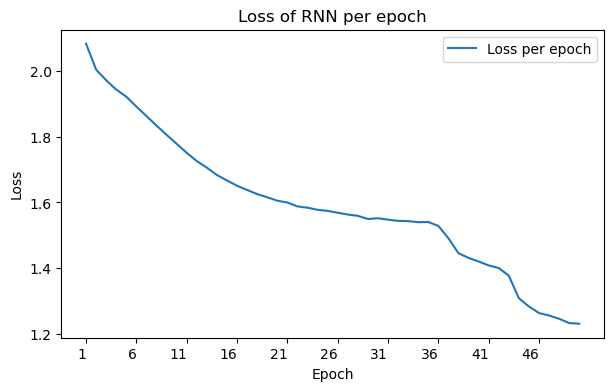

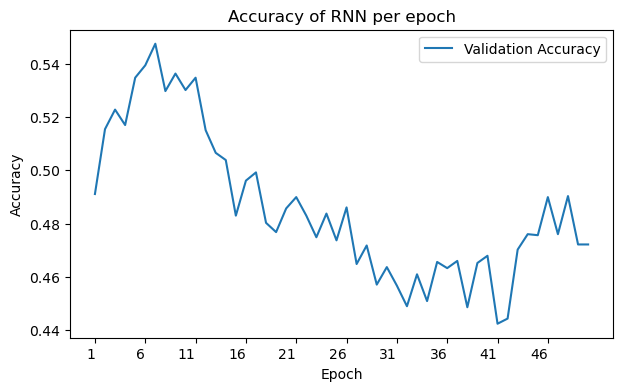

In [14]:
stats = torch.load(PATH_GENERATED_CONJ + 'best_models_stats.pt')
val_performance, losses = stats[0][1:]
best_model = torch.load(PATH_GENERATED_CONJ + 'conjugation_model.pt')

plot_scores(best_model, losses)
plot_scores(best_model, val_performance, loss=False)